# Numerical Solvers

Brain modeling toolkit provided in BrainPy is focused on **differential equations**. How to solve differential equations is the essence of the neurodynamics simulation. The exact algebraic solutions are only available for low-order differential equations. For the coupled high-dimensional non-linear brain dynamical systems, we need to resort to using numerical methods for solving such differential equations. In this section, I will illustrate how to define ordinary differential quations (ODEs), stochastic differential equations (SDEs), and how to define the numerical integration methods in BrainPy for these difined DEs.

In [1]:
import sys
sys.path.append('../../')

import brainpy as bp

## ODEs

### How to define an ODE function?

BrainPy provides a convenient and intuitive way to define ODE systems. For the ODE

$$
{dx \over dt} = f_1(x, t, y, p_1)\\
{dy \over dt} = f_2(y, t, x, p_2)
$$

we can define this system as a Python function: 

In [1]:
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

where `t` denotes the current time, `p1` and `p2` which after the `t` are represented as parameters needed in this system, and `x` and `y` passed before `t` denotes the dynamical variables. In the function body, the derivative for each variable can be customized by the user need `f1` and `f2`. Finally, we return the corresponding derivatives `dx` and `dy` with the order the same as the variables in the function arguments.

For each variable `x` or `y`, it can be a scalar (`var_type = bp.SCALAR_VAR`), a vector/matrix (`var_type = bp.POPU_VAR`), or a system (`var_type = bp.SYSTEM_VAR`). Here, the "system" means that the argument `x` denotes an array of vairables. Take the above example as the demonstration again, we can redefine it as:

In [6]:
import numpy as np

def diff(xy, t, p1, p2):
    x, y = xy
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return np.array([dx, dy])

### How to define the numerical integration for ODEs?

After the definition of ODE functions, the numerical integration of these functions are very easy in BrainPy. We just need put a decorator (`bp.odeint`). 

In [2]:
@bp.odeint
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

`bp.odeint` receives "method", "dt" etc. specification. By providing "method", user can specify the numerical methods to integrate the ODE functions. The supported ODE method can be found by

In [3]:
bp.integrators.SUPPORTED_ODE_METHODS

['bs',
 'ck',
 'euler',
 'heun2',
 'heun3',
 'heun_euler',
 'midpoint',
 'ralston2',
 'ralston3',
 'ralston4',
 'rk2',
 'rk3',
 'rk4',
 'rk4_38rule',
 'rkdp',
 'rkf12',
 'rkf45',
 'ssprk3']

Moreover, "dt" is a float which denotes the numerical integration precision. Here, for the above ODE function, we can define a four-order Runge-Kutta method for it:

In [4]:
@bp.odeint(method='rk4', dt=0.01)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

### Example 1: FitzHugh–Nagumo model

Here, let's take the well known [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) as an exmaple to illustrate how to define ODE solvers for brain modeling. The FitzHugh–Nagumo model (FHN) model has two dynamical variables, which are governed by the following equations:

$$
\begin{align}
\tau {\dot  {w}}&=v+a-bw\\
{\dot {v}} &=v-{\frac {v^{3}}{3}}-w+I_{\rm {ext}} \\
\end{align}
$$

For this FHN model, we can code it in BrainPy like this:

In [5]:
@bp.odeint(dt=0.01)
def integral(V, w, t, Iext, a, b, tau):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

After defining the numerical solver, the solution of the ODE system in the given times can be easily solved. For example, for the given parameters,

In [9]:
dt = 0.01;   a=0.7;   b=0.8;   tau=12.5;   Iext=1.

the solution of the FHN model between 0 and 100 ms can be approximated by 

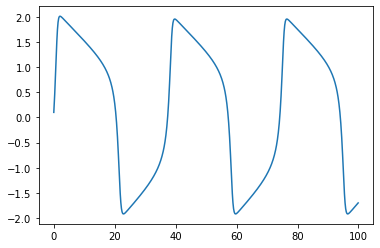

In [10]:
hist_times = np.arange(0, 100, 0.1)
hist_V = []
V, w = 0., 0.
for t in hist_times:
    V, w = integral(V, w, t, Iext, a, b, tau)
    hist_V.append(V)

import matplotlib.pyplot as plt
plt.plot(hist_times, hist_V)

### Example 2: Hodgkin–Huxley model

Another more complex example is the classical [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). In HH model, four dynamical variables (`V, m, n, h`) are used for modeling the initiation and propagration of the action potential. Specificaly, they are governed by the following equations:

$$
\begin{aligned}
C_{m} \frac{d V}{d t} &=-\bar{g}_{\mathrm{K}} n^{4}\left(V-V_{K}\right)- \bar{g}_{\mathrm{Na}} m^{3} h\left(V-V_{N a}\right)-\bar{g}_{l}\left(V-V_{l}\right)+I_{s y n} \\
\frac{d m}{d t} &=\alpha_{m}(V)(1-m)-\beta_{m}(V) m \\
\frac{d h}{d t} &=\alpha_{h}(V)(1-h)-\beta_{h}(V) h \\
\frac{d n}{d t} &=\alpha_{n}(V)(1-n)-\beta_{n}(V) n
\end{aligned}
$$

In BrainPy, such dynamical system can be coded as:

In [11]:
@bp.odeint(method='rk4', dt=0.01)
def integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta = 4.0 * np.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * np.exp(-(V + 65) / 20.)
    beta = 1 / (1 + np.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta = 0.125 * np.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

Same as the FHN model, we can also integrate the HH model in the given parameters and time interval:

In [16]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

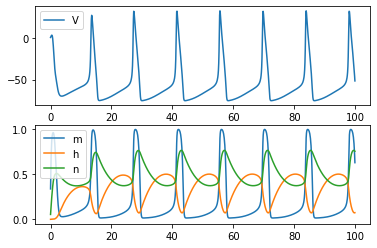

In [17]:
hist_times = np.arange(0, 100, 0.1)
hist_V, hist_m, hist_h, hist_n = [], [], [], []
V, m, h, n = 0., 0., 0., 0.
for t in hist_times:
    V, m, h, n = integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C)
    hist_V.append(V)
    hist_m.append(m)
    hist_h.append(h)
    hist_n.append(n)


plt.subplot(211)
plt.plot(hist_times, hist_V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(hist_times, hist_m, label='m')
plt.plot(hist_times, hist_h, label='h')
plt.plot(hist_times, hist_n, label='n')
plt.legend()

## SDEs

### How to define a SDE function?